- This notebook is to check the baseline model on surfactants dataset

In [3]:
import sys
sys.path.append("../src/models")
sys.path.append("../src")
sys.path.append("../")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio

In [3]:
from surfactants_cmc import get_train_data, train_model

In [5]:
from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.DataStructs import ConvertToNumpyArray

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
file_path = '/Users/haoliu/Documents/GitHub/FoundationModel_on_Liposome/data/SurfPro_v1/data/surfpro_literature.csv'
data = pd.read_csv(file_path)

df_ = data.iloc[:, [0, 1, 3]]
df_cleaned = df_.dropna()
df_data = df_cleaned.reset_index(drop=True)
df_data

,SMILES,Surfactant_Type,pCMC
0,C=CC(=O)OC(C[N+](C)(C)CCCCCCCCCCCC)C[N+](C)(C)...,gemini cationic,3.102373
1,C=CC(=O)OC(C[N+](C)(C)CCCCCCCCCCCCCC)C[N+](C)(...,gemini cationic,3.619789
2,C=CC(=O)OC(C[N+](C)(C)CCCCCCCCCCCCCCCC)C[N+](C...,gemini cationic,4.508638
3,C=CC(=O)OCC[N+](C)(C)CCCCCCCCCCCC.[Br-],cationic,2.384050
4,C=CC(=O)OCC[N+](C)(C)CCCCCCCCCCCCCC.[Br-],cationic,2.899629
...,...,...,...
1390,OCCOCCOCCOCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)...,non-ionic,4.432033
1391,OCCOCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,non-ionic,4.552997
1392,OCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,non-ionic,4.602060
1393,OCCOCCSCCOCCSCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)...,non-ionic,4.585027


In [6]:
# Construct RDKIT finger prints

In [7]:
# Convert SMILES to RDKit Mol objects
df_data['mol'] = df_data['SMILES'].apply(Chem.MolFromSmiles)

# Drop rows where mol conversion failed
df_data = df_data[df_data['mol'].notnull()].reset_index(drop=True)

,SMILES,Surfactant_Type,pCMC,mol
0,C=CC(=O)OC(C[N+](C)(C)CCCCCCCCCCCC)C[N+](C)(C)...,gemini cationic,3.102373,
1,C=CC(=O)OC(C[N+](C)(C)CCCCCCCCCCCCCC)C[N+](C)(...,gemini cationic,3.619789,
2,C=CC(=O)OC(C[N+](C)(C)CCCCCCCCCCCCCCCC)C[N+](C...,gemini cationic,4.508638,
3,C=CC(=O)OCC[N+](C)(C)CCCCCCCCCCCC.[Br-],cationic,2.384050,
4,C=CC(=O)OCC[N+](C)(C)CCCCCCCCCCCCCC.[Br-],cationic,2.899629,
...,...,...,...,...
1390,OCCOCCOCCOCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)...,non-ionic,4.432033,
1391,OCCOCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,non-ionic,4.552997,
1392,OCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,non-ionic,4.602060,
1393,OCCOCCSCCOCCSCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)...,non-ionic,4.585027,

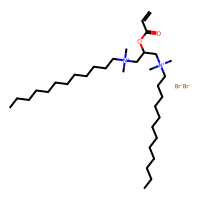
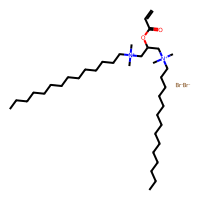
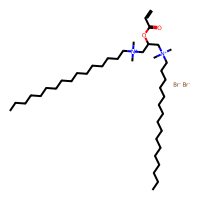
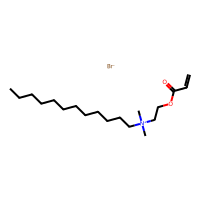
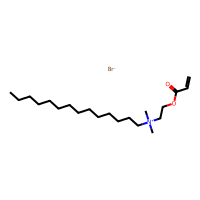
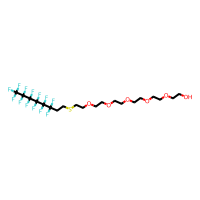
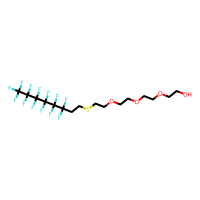
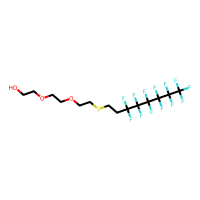
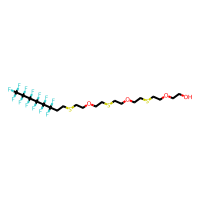
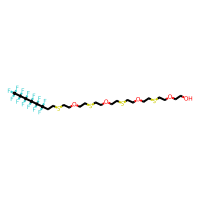

In [8]:
df_data

In [9]:
# Generate RDK Fingerprints
def mol_to_rdkfp(mol, fp_size=2048):
    fp = RDKFingerprint(mol, fpSize=fp_size)
    arr = np.zeros((1,))
    ConvertToNumpyArray(fp, arr)
    return arr

fp_array = np.array([mol_to_rdkfp(mol) for mol in df_data['mol']])

# Create DataFrame of fingerprint features
df_fp = pd.DataFrame(fp_array)
df_fp.columns = [f'RDKFP_{i}' for i in range(df_fp.shape[1])]

In [10]:
df_fp

,RDKFP_0,RDKFP_1,RDKFP_2,RDKFP_3,RDKFP_4,RDKFP_5,RDKFP_6,RDKFP_7,RDKFP_8,RDKFP_9,...,RDKFP_2038,RDKFP_2039,RDKFP_2040,RDKFP_2041,RDKFP_2042,RDKFP_2043,RDKFP_2044,RDKFP_2045,RDKFP_2046,RDKFP_2047
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1391,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1392,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1393,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [11]:
df_fp['pCMC'] = df_data['pCMC'].values

In [15]:
df_fp.to_csv('df_fingerprints_surfactants_20250426.csv',index=False)

In [10]:
df11 = pd.read_csv('df_total_surfactants_VICGAE_20250707.csv')
df11.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,Surfactant_Type,pCMC
0,0.126507,-0.292282,0.269726,0.197819,-0.310444,0.237475,0.039809,0.178617,0.210870,-0.314403,...,-0.250793,-0.337144,-0.238680,0.358088,0.300466,-0.239091,0.336340,-0.028181,gemini cationic,3.102373
1,0.161576,-0.316007,0.303903,0.219600,-0.327045,0.266383,0.035082,0.194145,0.247067,-0.341612,...,-0.268712,-0.352501,-0.279982,0.389918,0.314075,-0.287690,0.352540,-0.035765,gemini cationic,3.619789
2,0.204128,-0.345509,0.343564,0.259726,-0.360530,0.310840,0.039001,0.215532,0.292916,-0.369677,...,-0.297768,-0.397230,-0.307623,0.422857,0.343355,-0.322493,0.387318,-0.040816,gemini cationic,4.508638
3,0.070986,-0.156905,0.151639,0.119548,-0.164228,0.128342,0.052120,0.058778,0.127450,-0.175862,...,-0.138292,-0.161335,-0.124679,0.183632,0.167813,-0.130630,0.190421,-0.002939,cationic,2.384050
4,0.086600,-0.171577,0.167221,0.131681,-0.178890,0.142493,0.054071,0.068261,0.142623,-0.190378,...,-0.152449,-0.176851,-0.139739,0.199133,0.181108,-0.146197,0.202925,-0.006301,cationic,2.899629


In [11]:
df_total = pd.concat([df_fp, df11['Surfactant_Type']], axis=1)
# Reorder to make 'Surfactant_Type' the second last column
cols = list(df_total.columns)
cols.remove('Surfactant_Type')
cols.insert(-1, 'Surfactant_Type')
df_total = df_total[cols]
df_total.head()

,RDKFP_0,RDKFP_1,RDKFP_2,RDKFP_3,RDKFP_4,RDKFP_5,RDKFP_6,RDKFP_7,RDKFP_8,RDKFP_9,...,RDKFP_2040,RDKFP_2041,RDKFP_2042,RDKFP_2043,RDKFP_2044,RDKFP_2045,RDKFP_2046,RDKFP_2047,Surfactant_Type,pCMC
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,gemini cationic,3.102373
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,gemini cationic,3.619789
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,gemini cationic,4.508638
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,cationic,2.384050
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,cationic,2.899629


In [12]:
df_total.to_csv('df_total_surfactants_baseline_20250710.csv')

In [12]:
# Features and target
X = df_fp.drop(columns=['pCMC'])
y = df_fp['pCMC']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")


Test MSE: 0.7978
Test R²: 0.4380


In [9]:
# Features and target
X = df_fp.drop(columns=['pCMC'])
y = df_fp['pCMC']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=44)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")


Test MSE: 0.7951
Test R²: 0.4399


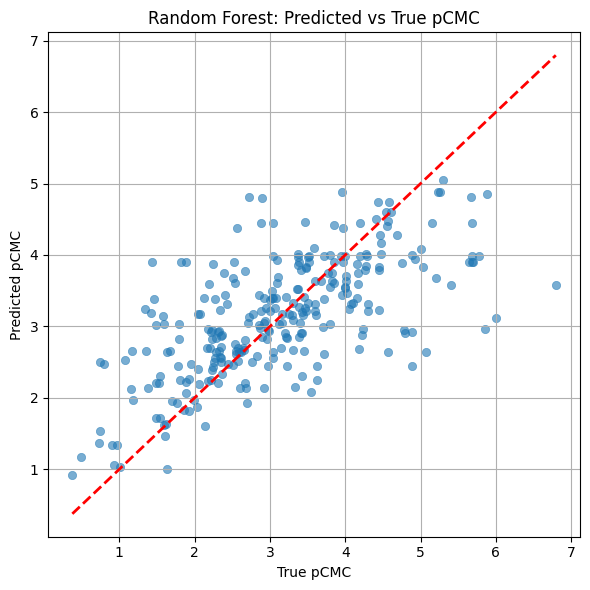

In [13]:
# Scatter plot of predicted vs actual
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)

# Reference line for perfect prediction
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel('True pCMC')
plt.ylabel('Predicted pCMC')
plt.title('Random Forest: Predicted vs True pCMC')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# Another way:

In [ ]:
from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.DataStructs import ConvertToNumpyArray
import numpy as np
import pandas as pd

smiles = df_data['SMILES']

# Generate fingerprints
fps = [RDKFingerprint(Chem.MolFromSmiles(s)) for s in smiles]

# Convert to numpy arrays
fp_array = []
for fp in fps:
    arr = np.zeros((1,))
    ConvertToNumpyArray(fp, arr)
    fp_array.append(arr)

# Create DataFrame
df_fp = pd.DataFrame(fp_array)
df_fp.columns = [f'RDKFP_{i}' for i in range(df_fp.shape[1])]

# Add target
df_fp['pCMC'] = df_data['pCMC'].values


In [18]:
df_fp

,RDKFP_0,RDKFP_1,RDKFP_2,RDKFP_3,RDKFP_4,RDKFP_5,RDKFP_6,RDKFP_7,RDKFP_8,RDKFP_9,...,RDKFP_2039,RDKFP_2040,RDKFP_2041,RDKFP_2042,RDKFP_2043,RDKFP_2044,RDKFP_2045,RDKFP_2046,RDKFP_2047,pCMC
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.102373
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.619789
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,4.508638
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.384050
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.899629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.432033
1391,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.552997
1392,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.602060
1393,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.585027
